In [7]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import random

#nilearn imports
from nilearn import plotting, image, interfaces
from nilearn.image import mean_img
from nilearn.plotting import plot_anat, plot_img, plot_stat_map, show, plot_design_matrix
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.reporting import get_clusters_table
import nilearn
import nibabel as nib

#sklearn imports
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

In [2]:
#load data
def load_beta_data():
    
    X, y = [], []
    
    directories = [Path("~/teams/a05/group_1_data/nonConfoundBeta/").expanduser(), 
    Path("~/teams/a05/group_1_data/nonConfoundBeta/betas/").expanduser()]

    for directory in directories:
        
        beta_files = list(directory.glob("beta_*.nii.gz"))

        for file_path in beta_files:
            
            file_name = file_path.stem
            subjID = file_name.split("_")[1]
            task = file_name.split("_")[2]

            beta_img = nib.load(str(file_path))
            beta_data = beta_img.get_fdata().flatten()
            
            X.append(beta_data)
            y.append(task)

    return np.array(X), np.array(y)

X, y = load_beta_data()

In [3]:
def split_train_test_valid(X, y): #split data into 20% test 20% validation 60% training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) #0.25 * 0.8 = 0.2
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_valid(X, y)

In [5]:
def NB_model(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return model

Model Accuracy: 0.5897


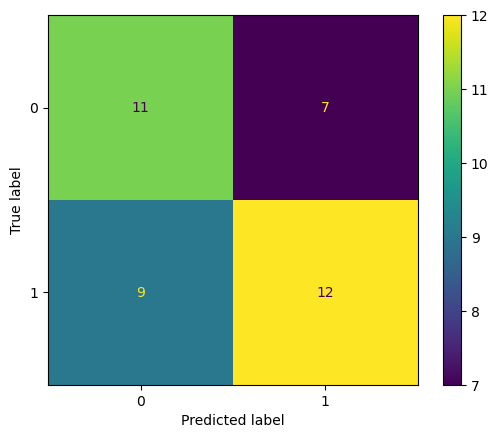

GaussianNB()

In [6]:
NB_model(X_train, y_train, X_test, y_test)

In [13]:
model = GaussianNB()

params = {'var_smoothing': np.logspace(0,-9, num=100)}
search = GridSearchCV(estimator=model, 
                 param_grid=params, 
                 #cv='cv_method',   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
search.fit(X_train, y_train)

search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 0.02848035868435802}

Model Accuracy: 0.6410


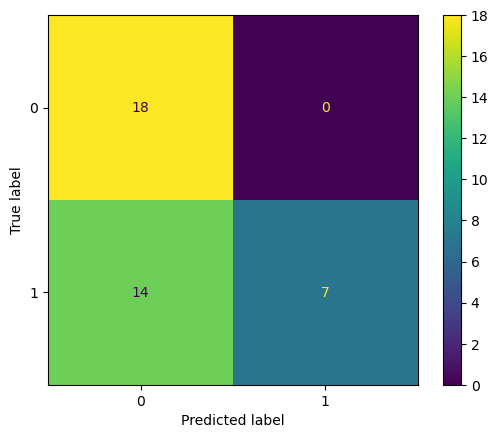

In [15]:
model = GaussianNB(var_smoothing=search.best_params_['var_smoothing'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
